In [4]:
# Import Pandas
import pandas as pd

# Load Movies Metadata
metadata = pd.read_csv('data/movies_metadata.csv', low_memory=False)
# low_memory=False help to speed up the panda when data is big(current dataset is almost 1GB)

# Take a look at the peek
metadata.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


# Broadly, recommender systems can be classified into 3 types:

- Simple recommenders: offer generalized recommendations to every user, based on movie popularity and/or genre. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience. IMDB Top 250 is an example of this system.
- Content-based recommenders: suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.
- Collaborative filtering engines: these systems try to predict the rating or preference that a user would give an item-based on past ratings and preferences of other users. Collaborative filters do not require item metadata like its content-based counterparts.

---
### Simple Recommenders
- Steps:
    - Decide on the metric or score to rate movies on
    - Calculate the score for every movie.
    - Sort the movies based on the score and output the top results.

- One of the most basic `metrics` you can think of is the **rating**. However, using this metric has a few `caveats`. For one, it does not take into consideration the `popularity of a movie`. Therefore, a movie with a rating of 9 from 10 voters will be considered 'better' than a movie with a rating of 8.9 from 10,000 voters.

- That is why, this metric will also tend to `favor` movies with `smaller number of voters` with `skewed` and/or extremely high ratings. As the number of voters increase, the rating of a movie regularizes and approaches towards a value that is reflective of the movie's quality. It is more difficult to discern the quality of a movie with extremely few voters.

- Since we are trying to re-build most popular 250IMDB movies, we are going to use **it weighted formula** as a metric score

Formule as follows: (v/v+m)*R + (m/v+m)*C
    
Where, 
- v is the number of votes for the movie;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the movie;
- C is the mean vote across the whole report

from the dataset we have v(vote_count), R(vote_average)

In [6]:
# we can calculate C
C = metadata['vote_average'].mean()
print(C)

5.618207215134185


We can see at the average vote is **5.6** on a scale 10

- Now we need to calculate the m - which we can define as the 90th percentile(this is could be any number but 90th makes more sense since we are trying to find top 250)

In [8]:
# m - minimum number votes required to be listed in the chart
m = metadata['vote_count'].quantile(0.90)
print(m)

160.0


- So, the movie to be considered to be in the list it must have at least **160** votes

In [11]:
qualified_movies = metadata.copy().loc[metadata['vote_count'] >= m]
qualified_movies.shape

(4555, 24)

In [12]:
# 4555 movies are qualified to be in the list now calculate the WR that we 
# defined earlier to find out has higher WR.
def weighted_rating(movie_x, m=m, C=C):
    """
    Calculates the weighted rating for each movie using our wr formula.
    Since, m and C are constant we are just using them for each movie
    
    Formule as follows: (v/v+m)R + (m/v+m)C

    v is the number of votes for the movie;
    m is the minimum votes required to be listed in the chart;
    R is the average rating of the movie;
    C is the mean vote across the whole report
    """
    v = movie_x['vote_count']
    R = movie_x['vote_average']
    
    wr = (v/(v+m)*R)+ (m/(v+m)*C)
    return wr
    

In [13]:
# first we need a new column for our score, so lets define it and assign the each movie its weighted rating(score)
# axis=1 applies the function for each row, if axis=0 then column
qualified_movies['score'] = qualified_movies.apply(weighted_rating, axis=1)

In [14]:
# lets sort the top 15 movies and take a glance at it if it is similar list what we have seen in IMDB list
qualified_movies = qualified_movies.sort_values('score', ascending=False)

# peek the top 15
qualified_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


- As you can see the list is kind of similar what is already in the IMDB website(since we are using only one metric to decide on, it is as accurate as original list😅)

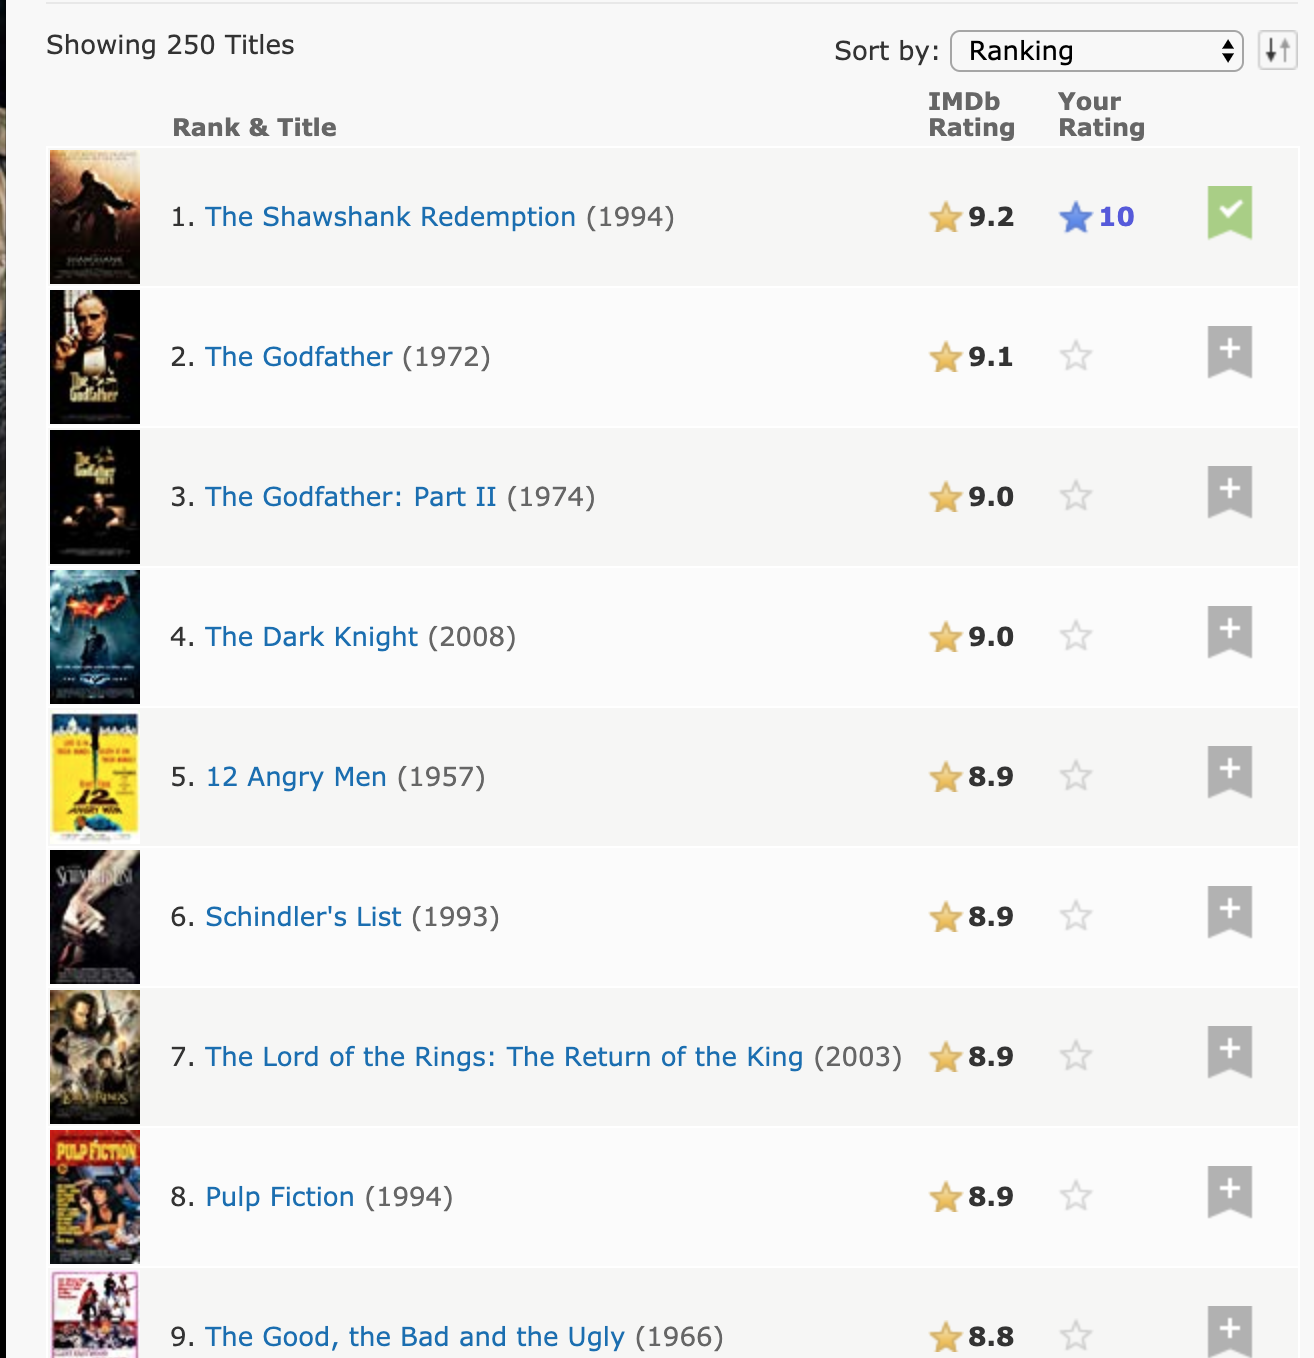

In [19]:
from IPython.display import Image
Image(filename="top_250_imdb.png", width=100, height=100)

<!-- ![title](top_250_imdb.png) -->

---

# Content-Based Recommender

In [ ]:
## Plot Description